In [1]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from fall_detection.fall.detection import StateDetector
from fall_detection.pose import YoloPoseModel, MediapipePoseModel, MovenetModel
from fall_detection.fall import PoseEmbedder, EstimatorClassifier
from fall_detection.fall import load_pose_samples_from_dir
from fall_detection.fall.embedding import COCO_POSE_KEYPOINTS
from fall_detection.utils import load_image, save_image

from fall_detection.fall.pipeline import Pipeline
from fall_detection.object_detection import YoloObjectDetector
import matplotlib.pyplot as plt
import cv2

In [2]:
# model to use -> select one
# model = "yolo"  # 'mediapipe' 'movenet'

if True:
    # YOLO MODEL
    pose_model = YoloPoseModel(model_path="../models/yolov8n-pose.pt")
    train_data_path = "../data/yolo-personal-dataset-train-csv/"
    dims = 3
    n_landmarks = 17

if False:
    # MEDIAPIPE
    pose_model = MediapipePoseModel()
    train_data_path = "../data/mediapipe-personal-dataset-train-csv/"
    dims = 3
    n_landmarks = 33

if False:
    # MOVENET
    pose_model = MovenetModel(model_name="movenet_thunder")
    train_data_path = "../data/movenet-personal-dataset-train-csv/"
    dims = 2
    n_landmarks = 17

object_model = YoloObjectDetector(model_path="../models/yolov8n.pt")

In [3]:
def show_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")

In [4]:
# load sample image
image = load_image("../tests/test_data/fall-sample.png")

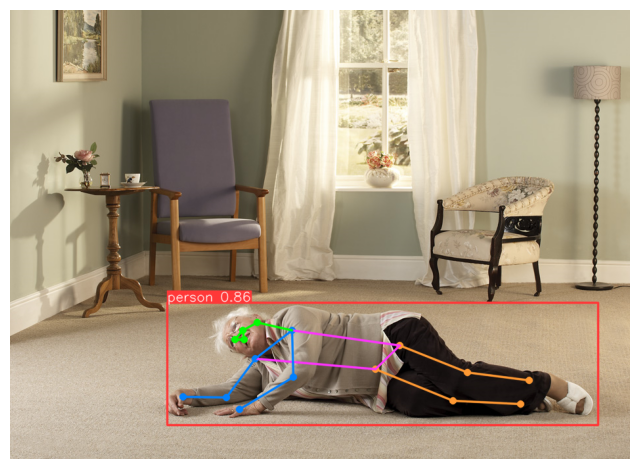

In [5]:
results = pose_model.predict(image)
img_out = pose_model.draw_landmarks(image, results)
show_image(img_out)

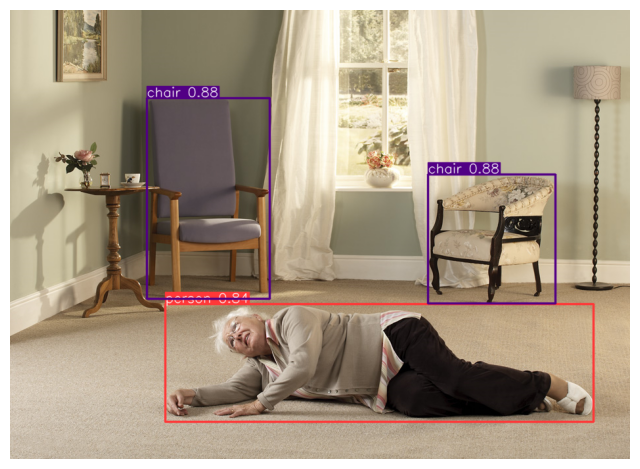

In [6]:
results = object_model.predict(image)
img_out = object_model.draw_results(image, results)
show_image(img_out)

In [7]:
# train classifier
from sklearn.ensemble import RandomForestClassifier


pose_embedder = PoseEmbedder(landmark_names=COCO_POSE_KEYPOINTS, dims=dims)

# classification_model = EstimatorClassifier(
#     estimator=make_pipeline(
#         StandardScaler(), LogisticRegression(random_state=42, max_iter=5000)
#     ),
#     pose_embedder=pose_embedder,
# )

classification_model = EstimatorClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42),
    pose_embedder,
    n_landmarks=n_landmarks,
    n_dimensions=dims,
)
detector = StateDetector(class_name="fall", enter_threshold=8, exit_threshold=4)

pose_samples = load_pose_samples_from_dir(
    pose_embedder=pose_embedder,
    n_landmarks=17,
    landmarks_dir=train_data_path,
    file_extension="csv",
    file_separator=",",
)
classification_model.fit(pose_samples)

2023-08-24 22:08:23,519 - fall-detection - INFO - Fitting on 7400 pose samples


In [8]:
# run prediction
pose_results = pose_model.predict(image)

pose_landmarks = pose_model.results_to_pose_landmarks(
    pose_results, image.shape[0], image.shape[1]
)

prediction = classification_model.predict(pose_landmarks)

prediction

{'fall': 10.0, 'nofall': 0.0}

{'classification': {'fall': 10.0, 'nofall': 0.0}, 'smooth_classification': {'fall': 10.0, 'nofall': 0.0}, 'detection': 1, 'message': 'Fall'}


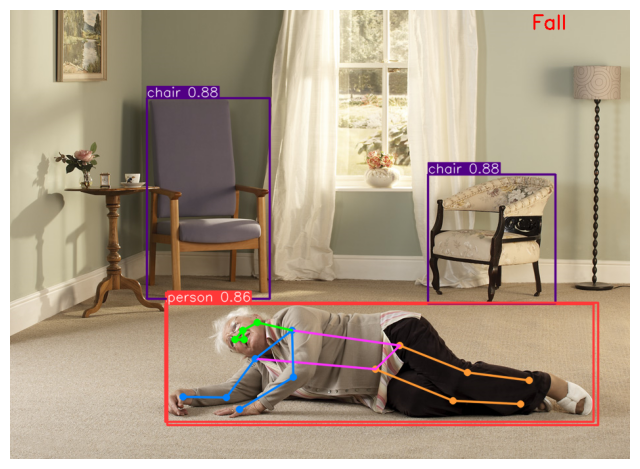

In [9]:
pipeline = Pipeline(
    pose_model=pose_model,
    object_model=object_model,
    classification_model=classification_model,
    detector=detector,
)

results = pipeline(image)

print(results[1])
show_image(results[0])

In [10]:
# Open the video.
import cv2
import numpy as np
import tqdm
from fall_detection.fall.plot import PoseClassificationVisualizer

path_video_in = "../data/videos/euge.mp4"
path_video_out = "../data/videos/euge_out.mp4"

video_cap = cv2.VideoCapture(path_video_in)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    class_name="Fall",
    plot_x_max=video_n_frames,
    plot_y_max=10,
    plot_location_x=0.05,
    plot_location_y=0.05,
    plot_max_width=1.0,
    plot_max_height=0.8,
    plot_figsize=(9, 4),
)

out_video = cv2.VideoWriter(
    path_video_out,
    cv2.VideoWriter_fourcc(*"mp4v"),
    video_fps,
    (video_width, video_height),
)

frame_idx = 0
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
    while True:
        # Get next frame of the video.
        success, input_frame = video_cap.read()
        if not success:
            break

        # Run pose tracker.
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

        output_frame, results = pipeline(input_frame)

        print(results["smooth_classification"])

        # Draw classification plot and repetition counter.
        output_frame = pose_classification_visualizer(
            frame=output_frame,
            pose_classification=results["classification"],
            pose_classification_filtered=results["smooth_classification"],
            detector_state=results["detection"],
        )

        # Save the output frame.
        out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

        frame_idx += 1
        pbar.update()

# Close output video.
out_video.release()

  0%|          | 1/249.0 [00:00<00:37,  6.60it/s]

{'fall': 4.11764705882353, 'nofall': 5.882352941176471}


  1%|          | 3/249.0 [00:00<00:46,  5.29it/s]

{'fall': 2.237442922374429, 'nofall': 7.762557077625571}
None


  2%|▏         | 5/249.0 [00:00<00:38,  6.35it/s]

{'fall': 3.1306750888274775, 'nofall': 6.869324911172522}
{'fall': 2.939309797699326, 'nofall': 7.060690202300674}


  2%|▏         | 6/249.0 [00:00<00:36,  6.60it/s]

{'fall': 1.9739423426731542, 'nofall': 8.026057657326847}
{'fall': 1.3286140827554684, 'nofall': 8.671385917244532}


  4%|▎         | 9/249.0 [00:01<00:39,  6.10it/s]

{'fall': 0.9374818638627799, 'nofall': 9.062518136137218}
{'fall': 0.6444108314384086, 'nofall': 9.355589168561592}


  4%|▍         | 11/249.0 [00:01<00:35,  6.67it/s]

{'fall': 0.5072120561867143, 'nofall': 9.492787943813287}
{'fall': 0.2678425130568519, 'nofall': 9.732157486943146}


  5%|▌         | 13/249.0 [00:02<00:33,  6.99it/s]

{'fall': 0.21836181840253485, 'nofall': 9.781638181597465}
{'fall': 0.18372533214451287, 'nofall': 9.816274667855485}


  6%|▌         | 15/249.0 [00:02<00:32,  7.16it/s]

{'fall': 0.08936506567792737, 'nofall': 9.910634934322072}
{'fall': 0.07075406440608716, 'nofall': 9.929245935593912}


  7%|▋         | 17/249.0 [00:02<00:32,  7.21it/s]

{'fall': 0.07952784508426099, 'nofall': 9.920472154915737}
{'fall': 0.08654155082172117, 'nofall': 9.913458449178277}


  8%|▊         | 19/249.0 [00:02<00:31,  7.24it/s]

{'fall': 0.09057908557520482, 'nofall': 9.909420914424793}
{'fall': 0.09427741916538183, 'nofall': 9.905722580834617}


  8%|▊         | 21/249.0 [00:03<00:31,  7.26it/s]

{'fall': 0.09512213415302881, 'nofall': 9.904877865846968}
{'fall': 0.06658549390712017, 'nofall': 9.933414506092877}


  9%|▉         | 23/249.0 [00:03<00:30,  7.31it/s]

{'fall': 0.045737786472245634, 'nofall': 9.954262213527754}
{'fall': 0.06201645053057194, 'nofall': 9.937983549469426}


 10%|█         | 25/249.0 [00:03<00:30,  7.32it/s]

{'fall': 0.07428357463413883, 'nofall': 9.92571642536586}
{'fall': 0.0511264429811587, 'nofall': 9.94887355701884}


 11%|█         | 27/249.0 [00:04<00:30,  7.34it/s]

{'fall': 0.03491645082407262, 'nofall': 9.965083549175924}
{'fall': 1.1967077082981747, 'nofall': 8.803292291701824}


 12%|█▏        | 29/249.0 [00:04<00:29,  7.35it/s]

{'fall': 2.195193944106477, 'nofall': 7.804806055893524}
{'fall': 1.5357637016117955, 'nofall': 8.464236298388204}


 12%|█▏        | 31/249.0 [00:04<00:29,  7.35it/s]

{'fall': 1.0741625318655184, 'nofall': 8.925837468134482}
{'fall': 0.7519137723058626, 'nofall': 9.248086227694138}


 13%|█▎        | 33/249.0 [00:04<00:31,  6.92it/s]

{'fall': 1.2055249443943508, 'nofall': 8.79447505560565}
{'fall': 0.8429954018133069, 'nofall': 9.157004598186694}


 14%|█▍        | 35/249.0 [00:05<00:30,  7.05it/s]

{'fall': 2.8120129889237466, 'nofall': 7.187987011076254}
{'fall': 3.8516047072736703, 'nofall': 6.14839529272633}


 15%|█▍        | 37/249.0 [00:05<00:29,  7.18it/s]

{'fall': 4.5484468508558775, 'nofall': 5.4515531491441225}
{'fall': 3.336006899191483, 'nofall': 6.663993100808516}


 16%|█▌        | 39/249.0 [00:05<00:29,  7.18it/s]

{'fall': 2.3585783403990215, 'nofall': 7.641421659600979}
None


 16%|█▋        | 41/249.0 [00:05<00:28,  7.18it/s]

None
{'fall': 1.712748956804792, 'nofall': 8.287251043195207}


 17%|█▋        | 43/249.0 [00:06<00:28,  7.30it/s]

None
None


 18%|█▊        | 45/249.0 [00:06<00:27,  7.30it/s]

{'fall': 1.229796329026093, 'nofall': 8.770203670973908}
{'fall': 0.9534736081064804, 'nofall': 9.04652639189352}


 19%|█▉        | 47/249.0 [00:06<00:27,  7.31it/s]

{'fall': 0.6482462218942896, 'nofall': 9.35175377810571}
{'fall': 0.45377235532600274, 'nofall': 9.546227644673996}


 20%|█▉        | 49/249.0 [00:07<00:27,  7.28it/s]

{'fall': 0.2857244410737698, 'nofall': 9.714275558926229}
{'fall': 0.17768355298733002, 'nofall': 9.822316447012668}


 20%|██        | 51/249.0 [00:07<00:27,  7.32it/s]

{'fall': 0.0720549313268222, 'nofall': 9.927945068673177}
{'fall': 0.04520609635234465, 'nofall': 9.954793903647653}


 21%|██▏       | 53/249.0 [00:07<00:26,  7.33it/s]

{'fall': 0.029900148921164292, 'nofall': 9.970099851078835}
{'fall': 1.7171492451699546, 'nofall': 8.282850754830044}


 22%|██▏       | 55/249.0 [00:07<00:26,  7.34it/s]

{'fall': 1.2011324123562297, 'nofall': 8.798867587643771}
None


 23%|██▎       | 57/249.0 [00:08<00:27,  6.92it/s]

{'fall': 0.8690485701238839, 'nofall': 9.130951429876115}
{'fall': 0.6083339990867186, 'nofall': 9.391666000913279}


 24%|██▎       | 59/249.0 [00:08<00:26,  7.12it/s]

{'fall': 0.45670585862344154, 'nofall': 9.543294141376556}
{'fall': 0.3496941010364091, 'nofall': 9.650305898963591}


 24%|██▍       | 61/249.0 [00:08<00:26,  7.20it/s]

{'fall': 0.27478587072548627, 'nofall': 9.725214129274514}
{'fall': 0.1923501095078404, 'nofall': 9.80764989049216}


 25%|██▌       | 63/249.0 [00:09<00:25,  7.24it/s]

{'fall': 0.13464507665548828, 'nofall': 9.86535492334451}
{'fall': 0.09425155365884179, 'nofall': 9.905748446341157}


 26%|██▌       | 64/249.0 [00:09<00:26,  7.03it/s]

{'fall': 0.04888488737331131, 'nofall': 9.951115112626686}
{'fall': 0.03421942116131792, 'nofall': 9.96578057883868}


 27%|██▋       | 67/249.0 [00:09<00:28,  6.39it/s]

{'fall': 0.02308153555018406, 'nofall': 9.976918464449813}
{'fall': 0.047029134147867316, 'nofall': 9.95297086585213}


 28%|██▊       | 69/249.0 [00:09<00:26,  6.86it/s]

None
None


 29%|██▊       | 71/249.0 [00:10<00:24,  7.15it/s]

None
None


 29%|██▉       | 73/249.0 [00:10<00:24,  7.31it/s]

None
None


 30%|███       | 75/249.0 [00:10<00:23,  7.35it/s]

None
{'fall': 0.15553657169172258, 'nofall': 9.844463428308277}


 31%|███       | 76/249.0 [00:10<00:23,  7.37it/s]

{'fall': 0.3241079557606367, 'nofall': 9.675892044239363}
None


 32%|███▏      | 79/249.0 [00:11<00:24,  7.08it/s]

{'fall': 0.28774762829518413, 'nofall': 9.712252371704817}
{'fall': 0.23229539906936741, 'nofall': 9.767704600930632}


 33%|███▎      | 81/249.0 [00:11<00:23,  7.20it/s]

{'fall': 0.19347883861129564, 'nofall': 9.806521161388702}
{'fall': 0.19717930555338392, 'nofall': 9.802820694446616}


 33%|███▎      | 83/249.0 [00:11<00:22,  7.28it/s]

{'fall': 0.19889757315010723, 'nofall': 9.801102426849893}
{'fall': 0.262716538256029, 'nofall': 9.73728346174397}


 34%|███▍      | 85/249.0 [00:12<00:22,  7.26it/s]

{'fall': 0.2765177545674357, 'nofall': 9.723482245432562}
{'fall': 0.25443448745994346, 'nofall': 9.745565512540054}


 35%|███▍      | 87/249.0 [00:12<00:23,  7.04it/s]

{'fall': 0.20548796343374495, 'nofall': 9.794512036566253}
{'fall': 0.2612253966154061, 'nofall': 9.738774603384591}


 36%|███▌      | 89/249.0 [00:12<00:22,  7.13it/s]

{'fall': 0.3046018961562612, 'nofall': 9.695398103843738}
{'fall': 0.42845368288581376, 'nofall': 9.571546317114183}


 37%|███▋      | 91/249.0 [00:13<00:21,  7.20it/s]

{'fall': 0.5151499335965005, 'nofall': 9.484850066403498}
{'fall': 0.5440931905685041, 'nofall': 9.455906809431493}


 37%|███▋      | 93/249.0 [00:13<00:21,  7.18it/s]

{'fall': 0.6569696482371224, 'nofall': 9.343030351762875}
{'fall': 0.6107508130287242, 'nofall': 9.389249186971274}


 38%|███▊      | 95/249.0 [00:13<00:21,  7.05it/s]

None
{'fall': 0.641013806171061, 'nofall': 9.358986193828938}


 39%|███▉      | 97/249.0 [00:13<00:21,  7.11it/s]

{'fall': 0.7865581976843891, 'nofall': 9.213441802315609}
{'fall': 0.8584392717437186, 'nofall': 9.141560728256279}


 39%|███▉      | 98/249.0 [00:14<00:21,  7.15it/s]

{'fall': 1.3074766162126346, 'nofall': 8.692523383787366}
{'fall': 2.1157557055446916, 'nofall': 7.884244294455308}


 41%|████      | 101/249.0 [00:14<00:21,  6.89it/s]

{'fall': 2.925911364390823, 'nofall': 7.0740886356091774}
{'fall': 3.5856365033713304, 'nofall': 6.414363496628667}


 41%|████▏     | 103/249.0 [00:14<00:20,  7.12it/s]

None
{'fall': 3.7395955672930397, 'nofall': 6.260404432706959}


 42%|████▏     | 105/249.0 [00:15<00:20,  7.19it/s]

{'fall': 2.980333074893343, 'nofall': 7.019666925106658}
{'fall': 4.119428767452388, 'nofall': 5.880571232547611}


 43%|████▎     | 107/249.0 [00:15<00:19,  7.33it/s]

None
None


 44%|████▍     | 109/249.0 [00:15<00:18,  7.38it/s]

None
None


 45%|████▍     | 111/249.0 [00:15<00:18,  7.41it/s]

None
None


 45%|████▌     | 113/249.0 [00:16<00:18,  7.39it/s]

None
None


 46%|████▌     | 115/249.0 [00:16<00:18,  7.39it/s]

None
None


 47%|████▋     | 117/249.0 [00:16<00:17,  7.45it/s]

None
None


 47%|████▋     | 118/249.0 [00:16<00:17,  7.51it/s]

None
None


 49%|████▊     | 121/249.0 [00:17<00:18,  7.02it/s]

None
None


 49%|████▉     | 123/249.0 [00:17<00:17,  7.22it/s]

None
None


 50%|█████     | 125/249.0 [00:17<00:17,  7.19it/s]

None
None


 51%|█████     | 127/249.0 [00:18<00:16,  7.28it/s]

None
None


 52%|█████▏    | 129/249.0 [00:18<00:16,  7.32it/s]

None
None


 53%|█████▎    | 131/249.0 [00:18<00:16,  7.24it/s]

None
None


 53%|█████▎    | 132/249.0 [00:18<00:16,  7.22it/s]

None
None


 54%|█████▍    | 135/249.0 [00:19<00:17,  6.64it/s]

None
None


 55%|█████▍    | 136/249.0 [00:19<00:16,  6.87it/s]

None
None


 56%|█████▌    | 139/249.0 [00:19<00:18,  6.07it/s]

None
None


 57%|█████▋    | 141/249.0 [00:20<00:16,  6.72it/s]

None
None


 57%|█████▋    | 143/249.0 [00:20<00:14,  7.10it/s]

None
None


 58%|█████▊    | 145/249.0 [00:20<00:14,  7.31it/s]

None
None


 59%|█████▉    | 147/249.0 [00:21<00:13,  7.43it/s]

None
None


 60%|█████▉    | 149/249.0 [00:21<00:13,  7.27it/s]

None
None


 61%|██████    | 151/249.0 [00:21<00:13,  7.45it/s]

None
None


 61%|██████▏   | 153/249.0 [00:21<00:12,  7.49it/s]

None
None


 62%|██████▏   | 155/249.0 [00:22<00:13,  6.93it/s]

None
None


 63%|██████▎   | 157/249.0 [00:22<00:13,  6.69it/s]

None
None


 64%|██████▍   | 159/249.0 [00:22<00:12,  7.03it/s]

None
None


 65%|██████▍   | 161/249.0 [00:22<00:12,  7.24it/s]

None
None


 65%|██████▌   | 163/249.0 [00:23<00:12,  7.15it/s]

None
None


 66%|██████▋   | 165/249.0 [00:23<00:11,  7.30it/s]

None
None


 67%|██████▋   | 167/249.0 [00:23<00:11,  7.41it/s]

None
None


 68%|██████▊   | 169/249.0 [00:24<00:10,  7.43it/s]

None
None


 69%|██████▊   | 171/249.0 [00:24<00:10,  7.44it/s]

None
None


 69%|██████▉   | 173/249.0 [00:24<00:10,  7.48it/s]

None
None


 70%|███████   | 175/249.0 [00:24<00:10,  7.03it/s]

None
None


 71%|███████   | 177/249.0 [00:25<00:09,  7.28it/s]

None
None


 72%|███████▏  | 179/249.0 [00:25<00:09,  7.37it/s]

None
None


 73%|███████▎  | 181/249.0 [00:25<00:09,  7.44it/s]

None
None


 73%|███████▎  | 183/249.0 [00:25<00:08,  7.49it/s]

None
None


 74%|███████▍  | 185/249.0 [00:26<00:08,  7.50it/s]

None
None


 75%|███████▌  | 187/249.0 [00:26<00:08,  7.37it/s]

None
None


 76%|███████▌  | 189/249.0 [00:26<00:08,  7.47it/s]

None
None


 77%|███████▋  | 191/249.0 [00:27<00:07,  7.51it/s]

None
None


 77%|███████▋  | 192/249.0 [00:27<00:07,  7.48it/s]

None
None


 78%|███████▊  | 194/249.0 [00:27<00:08,  6.83it/s]

None
None


 79%|███████▉  | 197/249.0 [00:27<00:07,  6.76it/s]

None
None


 80%|███████▉  | 199/249.0 [00:28<00:07,  7.05it/s]

None
None


 81%|████████  | 201/249.0 [00:28<00:06,  7.28it/s]

None
None


 82%|████████▏ | 203/249.0 [00:28<00:06,  7.10it/s]

None
None


 82%|████████▏ | 205/249.0 [00:29<00:06,  7.26it/s]

None
None


 83%|████████▎ | 207/249.0 [00:29<00:05,  7.26it/s]

None
None


 84%|████████▍ | 209/249.0 [00:29<00:05,  6.93it/s]

None
None


 85%|████████▍ | 211/249.0 [00:30<00:06,  5.98it/s]

None
None


 86%|████████▌ | 213/249.0 [00:30<00:05,  6.48it/s]

None
None


 86%|████████▋ | 215/249.0 [00:30<00:04,  6.84it/s]

None
None


 87%|████████▋ | 217/249.0 [00:30<00:04,  6.54it/s]

None
None


 88%|████████▊ | 219/249.0 [00:31<00:04,  6.59it/s]

None
None


 89%|████████▉ | 221/249.0 [00:31<00:04,  6.56it/s]

None
None


 90%|████████▉ | 223/249.0 [00:31<00:03,  6.57it/s]

None
None


 90%|████████▉ | 224/249.0 [00:31<00:03,  6.68it/s]

None
None


 91%|█████████ | 227/249.0 [00:32<00:03,  5.56it/s]

None
None


 92%|█████████▏| 228/249.0 [00:32<00:03,  5.74it/s]

None
None


 93%|█████████▎| 231/249.0 [00:33<00:02,  6.19it/s]

None
None


 94%|█████████▎| 233/249.0 [00:33<00:02,  6.44it/s]

None
None


 94%|█████████▍| 235/249.0 [00:33<00:02,  6.93it/s]

None
None


 95%|█████████▌| 237/249.0 [00:34<00:01,  6.76it/s]

None
None


 96%|█████████▌| 239/249.0 [00:34<00:01,  7.05it/s]

None
None


 97%|█████████▋| 241/249.0 [00:34<00:01,  7.33it/s]

None
None


 98%|█████████▊| 243/249.0 [00:34<00:00,  7.52it/s]

None
None


 98%|█████████▊| 244/249.0 [00:35<00:00,  7.18it/s]

None
None


 99%|█████████▉| 247/249.0 [00:35<00:00,  7.10it/s]

None
None


100%|██████████| 249/249.0 [00:35<00:00,  6.96it/s]

None
None
